<a href="https://colab.research.google.com/github/All3yp/knn_c_v2/blob/main/PROJ_KNN_SEMB_Colab_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto SEMB — Classificação de Sinais Ultrassônicos com KNN

In [18]:
# !rm -rf /content/dataset

### 📁 Verificação e Extração do Dataset

In [19]:
from zipfile import ZipFile
from google.colab import drive
import os
import sys

# Montar o Google Drive
drive.mount('/content/drive')

# Caminhos no Google Drive
drive_base = "/content/drive/MyDrive/Colab Notebooks"
zip_path = f"{drive_base}/dataset_isolador.zip"
extract_to = "/content"
extracted_path = f"{extract_to}/dataset_isolador/amostras"

# Checagem se o dataset já foi extraído
if os.path.isdir(extracted_path):
    print(f"Diretório '{extracted_path}' já existe. Pulando extração.")
else:
    if not os.path.exists(zip_path):
        print(f"'{zip_path}' não encontrado no Google Drive. Por favor, faça o upload manual.")
        sys.exit("Encerrando.")

    print(f"Extraindo '{zip_path}' para '{extract_to}'...")
    os.makedirs(extract_to, exist_ok=True)
    with ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extração concluída.")

    if not os.path.isdir(extracted_path):
        print(f"Aviso: '{extracted_path}' não encontrado após extração.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Diretório '/content/dataset_isolador/amostras' já existe. Pulando extração.


In [20]:
# Instalar dependências no Colab
!pip install scikit-learn numpy matplotlib seaborn

## 1. Carregamento dos Sinais `.txt`

In [21]:
import os
import numpy as np
def load_dataset(base_path):
    X, y = [], []
    for class_name in sorted(os.listdir(base_path)):
        path = os.path.join(base_path, class_name)
        if not os.path.isdir(path): continue
        label = int(class_name[0])
        for fname in os.listdir(path):
            if fname.endswith('.txt'):
                with open(os.path.join(path, fname)) as f:
                    values = [float(line.strip()) for line in f if line.strip()]
                    if len(values) == 5000:
                        X.append(np.array(values) / 4096.0)
                        y.append(label)
    return X, y


base_path = "/content/dataset_isolador/amostras"
X_raw, y = load_dataset(base_path)
print(f"Total de amostras: {len(X_raw)}")

Total de amostras: 1465


## 2. Visualização: Forma de Onda + Espectrograma

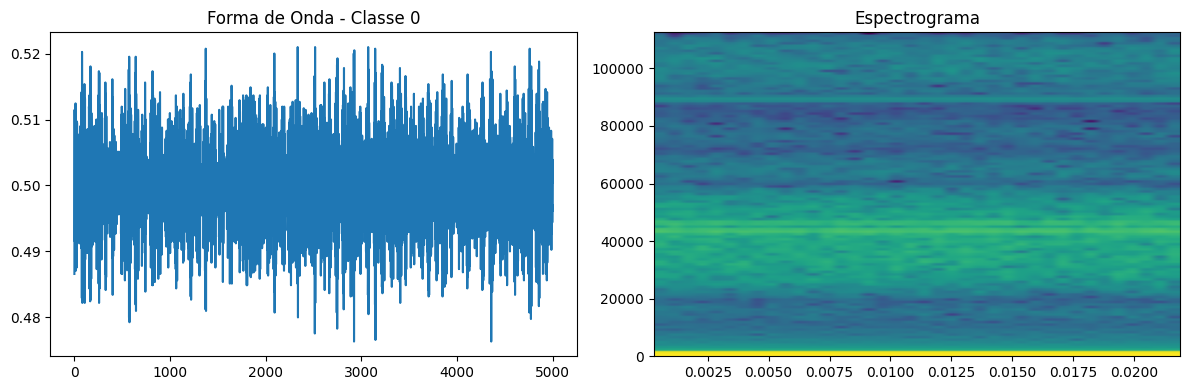

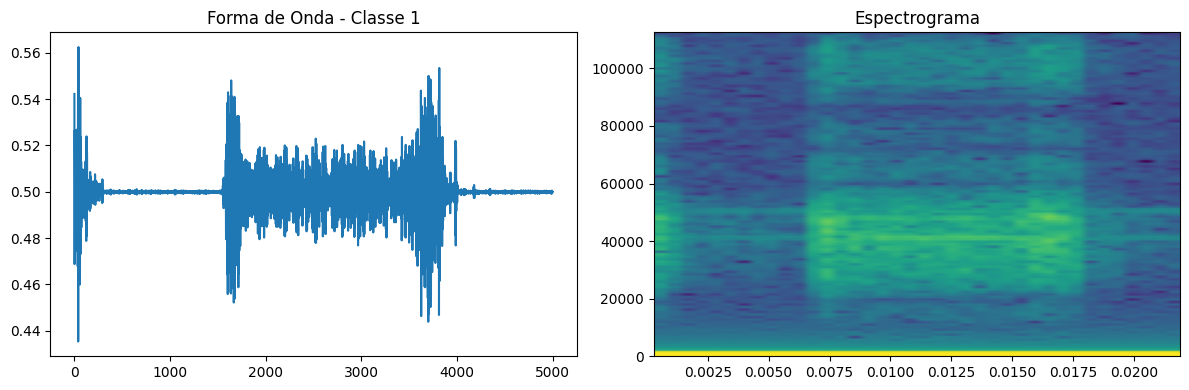

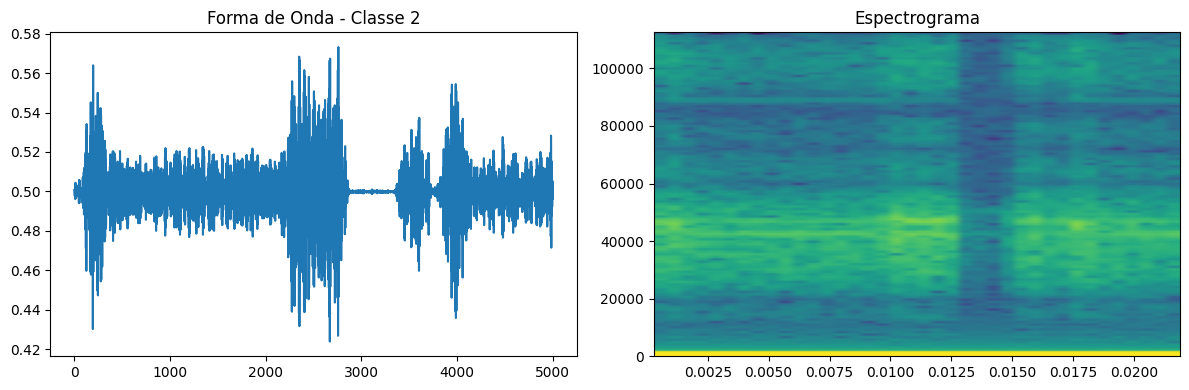

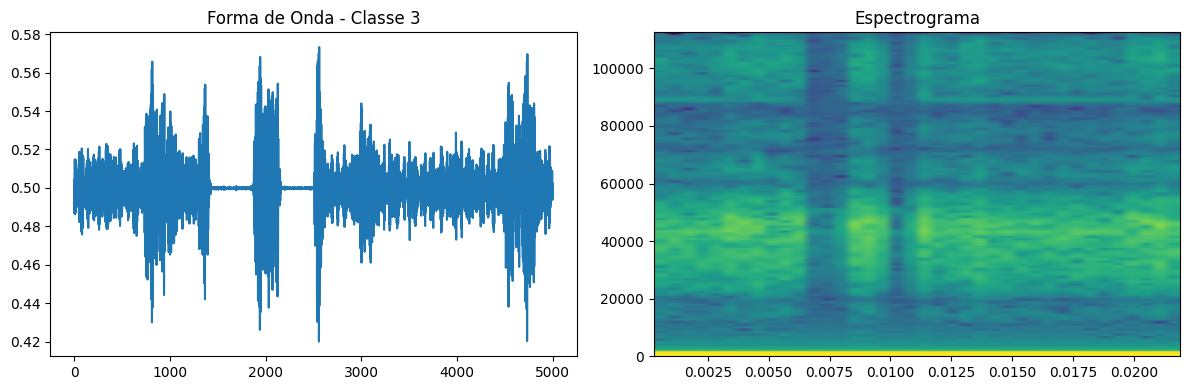

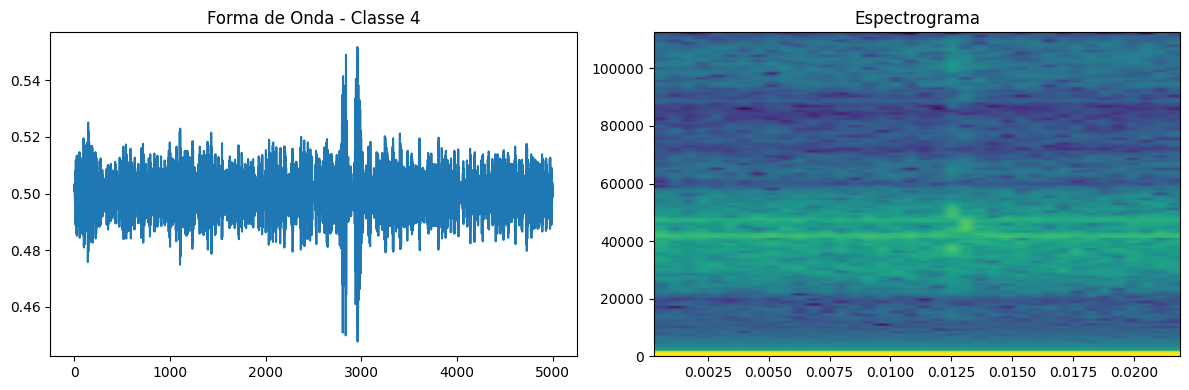

In [22]:
import matplotlib.pyplot as plt
def plot_waveform_and_spectrogram(signal, class_label):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(signal)
    plt.title(f"Forma de Onda - Classe {class_label}")
    plt.subplot(1, 2, 2)
    plt.specgram(signal, NFFT=256, Fs=225000, noverlap=128)
    plt.title("Espectrograma")
    plt.tight_layout()
    plt.show()

# Classe por tipo de sinal
shown = set()
for s, label in zip(X_raw, y):
    if label not in shown:
        plot_waveform_and_spectrogram(s, label)
        shown.add(label)
    if len(shown) == 5:
        break

## 3. Extração de Características (12 features)

In [23]:
def extract_features(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    peaks = -np.sort(-np.abs(signal))[:10]
    return np.hstack([mean, std, peaks])

X_features = [extract_features(s) for s in X_raw]
X = np.array(X_features)
y = np.array(y)

## 4. Classificação com KNN
Aplicação do KNN para prever a classe dos sinais a partir das 12 features extraídas.

### 4.1. Comparação de Acurácia com Vários Valores de K

Teste com vários valores e observar qual ofereceria o melhor desempenho.

Queremos identificar com base na acurácia no conjunto de teste.

K =  1 → Acurácia: 70.65%
K =  3 → Acurácia: 73.04%
K =  5 → Acurácia: 74.06%
K =  7 → Acurácia: 75.09%
K =  9 → Acurácia: 76.79%
K = 11 → Acurácia: 76.79%
K = 13 → Acurácia: 77.82%
K = 15 → Acurácia: 78.84%


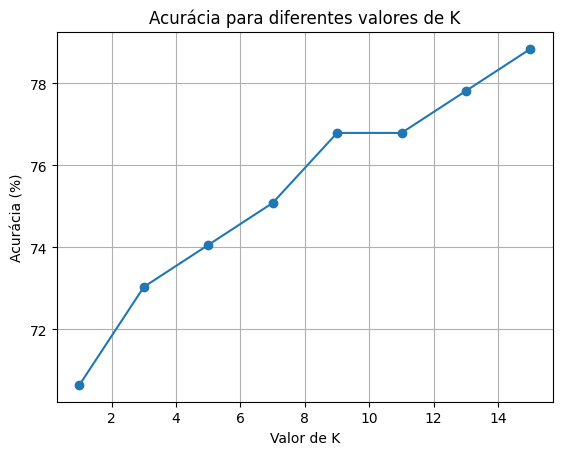

In [24]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

valores_k = [1, 3, 5, 7, 9, 11, 13, 15]
acuracias = []

# Divisão e normalização
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

for k in valores_k:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acuracias.append(acc)
    print(f"K = {k:2d} → Acurácia: {acc * 100:.2f}%")

# Gráfico
plt.plot(valores_k, [a * 100 for a in acuracias], marker='o')
plt.title("Acurácia para diferentes valores de K")
plt.xlabel("Valor de K")
plt.ylabel("Acurácia (%)")
plt.grid(True)
plt.show()

### 4.2. Treinamento final com o melhor valor de K

Após os testes, o valor de K = 15 irá treinar definitivamente o classificador. A seguir, mostro a acurácia final com esse valor, que será usado para gerar a matriz de confusão.

In [25]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Acurácia: {acc * 100:.2f}%")

Acurácia: 78.84%


## 5. Tempo Médio de Inferência

In [26]:
import time

# Tempo de inferência
start = time.time()
for x in X_test:
    _ = knn.predict([x])
end = time.time()

tempo_total = end - start
tempo_medio = tempo_total / len(X_test)
print(f"Tempo médio de inferência por amostra: {tempo_medio * 1000:.4f} ms")

# Estimativa de energia (como foi feito no knn_c)
tensao = 3.3  # volts
corrente = 0.08  # amperes
energia = tensao * corrente * tempo_medio  # tempo em segundos
print(f"Energia estimada por inferência: {energia:.6f} J")

Tempo médio de inferência por amostra: 2.9852 ms
Energia estimada por inferência: 0.000788 J


## 6.1. ANOVA

ANOVA é um teste estatístico usado para descobrir quais das 12 features (características extraídas dos sinais) são mais úteis para distinguir entre as diferentes classes. Ele usa o F-score para indicar a relevância da feature (maior F-score significa maior relevância) e o p-valor para verificar a significância estatística do resultado.

[Link de ref da documentação aqui](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html)

In [27]:
from sklearn.feature_selection import f_classif

# Aplica ANOVA F-test
f_vals, p_vals = f_classif(X, y)

# Exibe o ranking das features
print("Ranking das features por F-score (ANOVA):")
for i, f in sorted(enumerate(f_vals), key=lambda x: -x[1]):
    print(f"Feature {i:2d} -> F = {f:.2f} | p = {p_vals[i]:.2e}")

Ranking das features por F-score (ANOVA):
Feature  1 -> F = 688.12 | p = 0.00e+00
Feature 11 -> F = 369.41 | p = 8.05e-220
Feature 10 -> F = 362.76 | p = 6.11e-217
Feature  9 -> F = 345.67 | p = 2.02e-209
Feature  7 -> F = 344.54 | p = 6.45e-209
Feature  8 -> F = 342.04 | p = 8.49e-208
Feature  6 -> F = 329.86 | p = 2.68e-202
Feature  4 -> F = 315.29 | p = 1.38e-195
Feature  5 -> F = 315.03 | p = 1.82e-195
Feature  3 -> F = 308.22 | p = 2.78e-192
Feature  2 -> F = 307.83 | p = 4.26e-192
Feature  0 -> F = 1.28 | p = 2.77e-01


## 6.2. Matriz de Confusão
A **matriz de confusão** permite visualizar em quais classes o modelo está acertando e errando, já que cada linha representa a **classe real**, e cada coluna representa a **classe predita**.  
Os números altos na diagonal indicam acertos. Valores fora da diagonal são erros de classificação.
[Link de referencia aqui](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

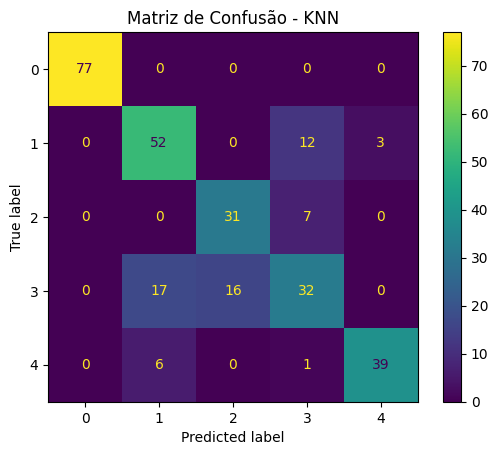

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test)
plt.grid(False)
plt.title("Matriz de Confusão - KNN")
plt.show()

## 6. Ranking das Features (ANOVA)

Mostra a relevância de cada uma das 12 features para a classificação, usando F-score e p-valor.

[Link de ref da documentação aqui](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html)

In [29]:
from sklearn.feature_selection import f_classif
f_vals, p_vals = f_classif(X, y)
for i, f in enumerate(f_vals):
    print(f"Feature {i}: F = {f:.2f}  | p = {p_vals[i]:.2e}")

Feature 0: F = 1.28  | p = 2.77e-01
Feature 1: F = 688.12  | p = 0.00e+00
Feature 2: F = 307.83  | p = 4.26e-192
Feature 3: F = 308.22  | p = 2.78e-192
Feature 4: F = 315.29  | p = 1.38e-195
Feature 5: F = 315.03  | p = 1.82e-195
Feature 6: F = 329.86  | p = 2.68e-202
Feature 7: F = 344.54  | p = 6.45e-209
Feature 8: F = 342.04  | p = 8.49e-208
Feature 9: F = 345.67  | p = 2.02e-209
Feature 10: F = 362.76  | p = 6.11e-217
Feature 11: F = 369.41  | p = 8.05e-220


## 7. Exportação do CSV com Features

In [30]:
import pandas as pd
df = pd.DataFrame(X, columns=['mean', 'std'] + [f'p{i+1}' for i in range(10)])
df['class'] = y
df.to_csv("dataset_features.csv", index=False)
df.head()

,mean,std,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,class
0,0.499878,0.007154,0.520996,0.520996,0.520996,0.520752,0.520752,0.520752,0.520508,0.520264,0.520264,0.520020,0
1,0.499877,0.007312,0.523193,0.520996,0.520996,0.520508,0.520508,0.520020,0.520020,0.519531,0.519531,0.519287,0
2,0.499879,0.007281,0.523438,0.521973,0.520752,0.520752,0.520264,0.519775,0.519775,0.519775,0.519043,0.519043,0
3,0.499877,0.007167,0.520508,0.520508,0.519775,0.519531,0.519531,0.519287,0.519043,0.518799,0.518311,0.518311,0
4,0.499877,0.006982,0.521729,0.519531,0.519287,0.519287,0.518555,0.518311,0.518066,0.517822,0.517822,0.517822,0


## 8. Aplicação de LDA e Visualização

 Utiliza a Análise Discriminante Linear (LDA) para reduzir as 12 features dos dados a 2 ou 4 componentes para visualização e exportação, ajudando a entender a separabilidade das classes.

Fonte de [referencia aqui](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)

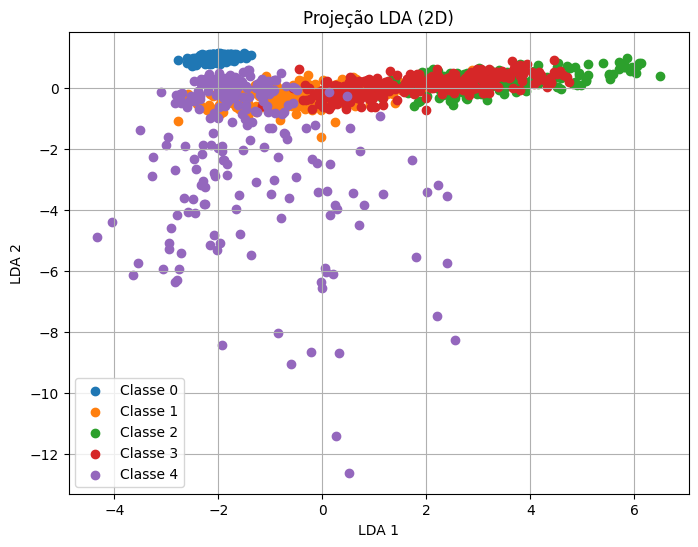

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X, y)
plt.figure(figsize=(8,6))
for c in np.unique(y):
    plt.scatter(X_lda[y==c,0], X_lda[y==c,1], label=f"Classe {c}")
plt.legend()
plt.title("Projeção LDA (2D)")
plt.xlabel("LDA 1")
plt.ylabel("LDA 2")
plt.grid(True)
plt.show()

In [32]:
df_lda_2d = pd.DataFrame(X_lda, columns=['lda_1', 'lda_2'])
df_lda_2d['class'] = y
df_lda_2d.to_csv("dataset_improved.csv", index=False)
df_lda_2d.head()

,lda_1,lda_2,class
0,-2.057137,0.969772,0
1,-1.881349,0.967331,0
2,-2.063606,1.088297,0
3,-2.017506,1.097107,0
4,-2.183855,1.001161,0


In [33]:
lda4 = LinearDiscriminantAnalysis(n_components=4)
X_lda4 = lda4.fit_transform(X, y)
df_lda_4d = pd.DataFrame(X_lda4, columns=[f'lda_{i+1}' for i in range(4)])
df_lda_4d['class'] = y
df_lda_4d.to_csv("dataset_lda.csv", index=False)
df_lda_4d.head()

,lda_1,lda_2,lda_3,lda_4,class
0,-2.057137,0.969772,0.309434,0.225384,0
1,-1.881349,0.967331,-0.075851,-0.065769,0
2,-2.063606,1.088297,-0.186143,-0.108551,0
3,-2.017506,1.097107,-0.189396,-0.009765,0
4,-2.183855,1.001161,-0.011022,-0.123853,0


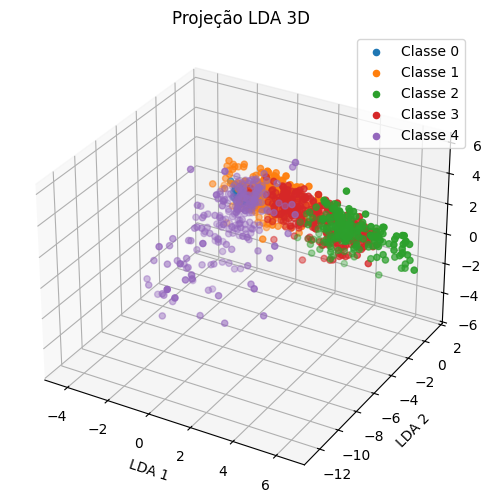

In [34]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
for label in np.unique(y):
    ax.scatter(X_lda4[y == label, 0], X_lda4[y == label, 1], X_lda4[y == label, 2], label=f'Classe {label}')
ax.set_title("Projeção LDA 3D")
ax.set_xlabel("LDA 1")
ax.set_ylabel("LDA 2")
ax.set_zlabel("LDA 3")
ax.legend()
plt.show()

# Comparação visual mocada de ambos os projetos

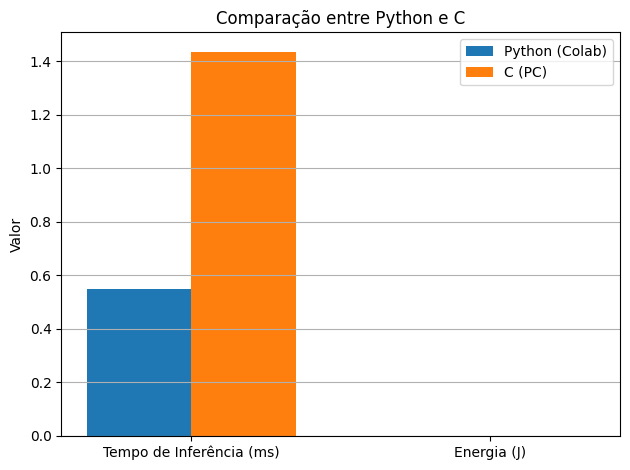

In [35]:
import matplotlib.pyplot as plt

metrica = ['Tempo de Inferência (ms)', 'Energia (J)']
c = [1.437, 0.00038]  # dados do projeto em C mocado
py = [0.5489, 0.000145]  # dados do projeto em Python mocado

bar_width = 0.35
x = range(len(metrica))

plt.bar(x, py, width=bar_width, label='Python (Colab)')
plt.bar([i + bar_width for i in x], c, width=bar_width, label='C (PC)')

plt.xticks([i + bar_width/2 for i in x], metrica)
plt.ylabel('Valor')
plt.title('Comparação entre Python e C')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()
